<a href="https://colab.research.google.com/github/BaharehAm/Python-tutorials-for-Advanced-Data-Mining/blob/main/Tutorial_8_TCNN%2C_Autoencoder(Reg%2CCls)%2C_Ensembe_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data for Regression

In [ ]:
%%capture
pip install yfinance

In [ ]:
import yfinance as yf
data = yf.download("AAPL", start="2021-01-01", end="2022-03-15")
len(data)
data
data.reset_index(inplace=True)
data.head()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-04,133.520004,133.610001,126.760002,129.410004,127.679993,143301900
1,2021-01-05,128.889999,131.740005,128.429993,131.009995,129.258606,97664900
2,2021-01-06,127.720001,131.050003,126.379997,126.599998,124.907555,155088000
3,2021-01-07,128.360001,131.630005,127.860001,130.919998,129.169815,109578200
4,2021-01-08,132.429993,132.630005,130.229996,132.050003,130.284698,105158200


In [ ]:
## Data scaling
from sklearn.preprocessing import MinMaxScaler
data_close = data[['Close']]
data_close
sc = MinMaxScaler(feature_range = (0, 1))
data_close_sc = sc.fit_transform(data_close)
data_close_sc
len(data_close_sc)

301

In [ ]:
def prepare_data(data, ratio, h):
  '''
   if you want to prepare data for hyper-prameter tuning, set ratio = 0.80, then, the test_size will be the size of your validation set
   after finding your optimal hyper-parameters, you need to call the prepare_data function once again for the purpose of model evaluation and you should set ratio = 1.0
   '''
  data_size = int(ratio * len(data))
  data = data[:data_size]

  train_size = int(len(data) * 0.80)
  test_size = len(data)-train_size
  ## prepare the training set for training the model
  train_set = data[:train_size]
  test_set = data[train_size : train_size + test_size]
  X_train = []
  y_train = []
  for i in range(h, train_size):
    X_train.append(train_set[i-h:i])                         ## Xt:(C_t-h, ... , C_t-1) ==> yt:C_t
    y_train.append(train_set[i])
  X_train, y_train = np.array(X_train), np.array(y_train)

  ## prepare the test set for making predictions
  temp = data[train_size-h : train_size + test_size]
  X_test = []
  for i in range(h, len(temp)):
    X_test.append(temp[i-h:i])
  X_test = np.array(X_test)
  y_test = np.array(test_set)
  return X_train, y_train, X_test, y_test, train_size, test_size

In [ ]:
h = 30  ## long sequence
ratio = 1
input = prepare_data(data_close_sc, ratio, h)

X_train = input[0]
y_train = input[1]
X_test = input[2]
y_test = input[3]

In [ ]:
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (210, 30, 1)
y_train:  (210, 1)
X_test:  (61, 30, 1)
y_test (61, 1)


# TCNN model

**A Good [Resource](https://unit8.com/resources/temporal-convolutional-networks-and-forecasting/) to learn TCNN**

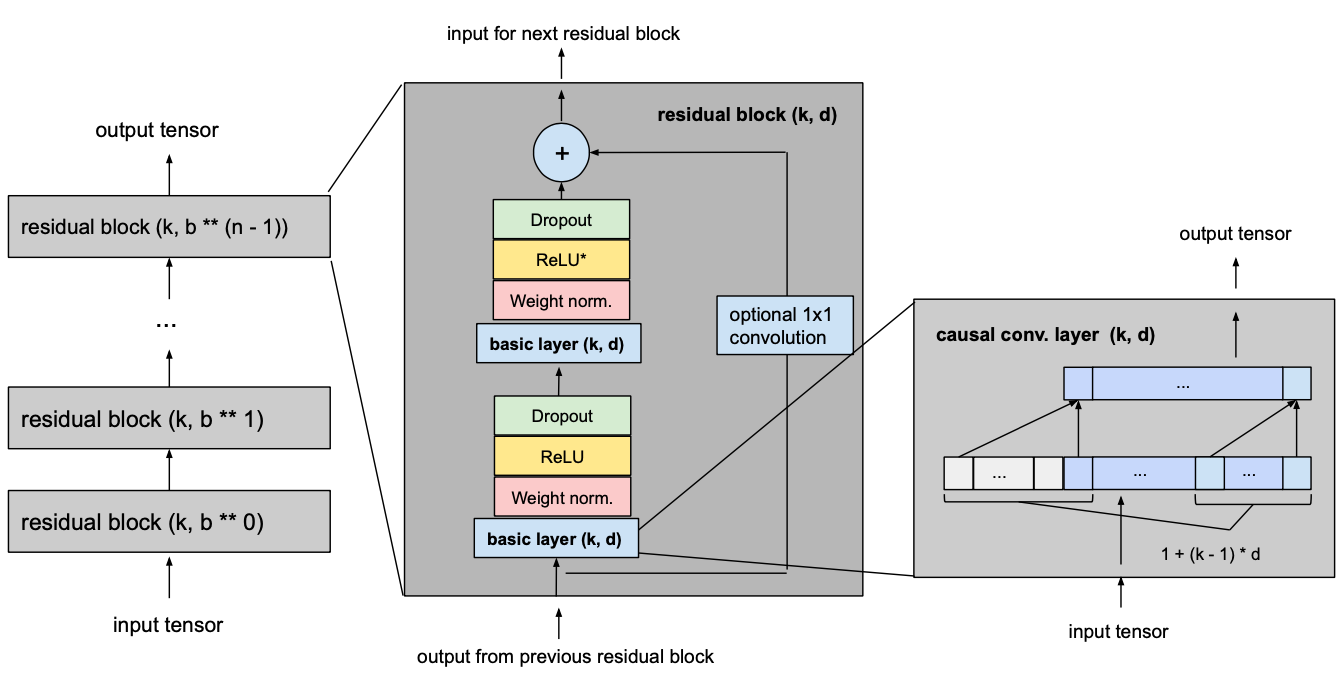

The most important component of TCNNs is **dilated causal convolution**. “Causal” simply means a filter at time step t can only see inputs that are no later than t. Dilated causal convolutions can process a wider range of temporal information by allowing the convolutional kernel to **skip time steps**. This can be useful for modeling long-term dependencies in time series data

In the context of TCNN, **residual blocks** can be used to improve the performance of the network, especially for long temporal sequences. The residual block consists of a series of convolutional layers followed by a shortcut connection that bypasses the convolutional layers and adds the original input to the output of the convolutional layers. This allows the network to learn the residual mapping, i.e., the difference between the input and the desired output, which can be more efficient than learning the entire mapping from scratch.

In TCNN with residual blocks, the network consists of multiple layers of residual blocks, with each block processing the input sequence and producing a new sequence as output. The output of each block is then fed as input to the next block, and the final output of the network is produced by a fully connected layer or another type of output layer.


To use both residual blocks and dilated causal convolutions in a TCNN model, you can combine these techniques within the same layer. For example, you can use a residual block that includes dilated causal convolutions. In this case, the **skip connection** would need to be adapted to handle the dilated convolutional output. A skip connection involves passing the output of one layer directly to a later layer without any modification. This can be helpful in allowing the network to learn long-term dependencies, as information from earlier layers can bypass intermediate layers and directly influence the output of later layers.

In [ ]:
X_train.shape

(210, 30, 1)

2/2 [==============================] - 0s 10ms/step - loss: 0.0110
Test MSE: 0.011


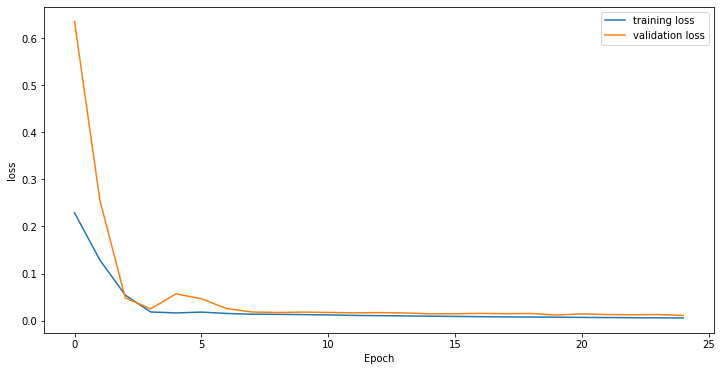

In [ ]:
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Add, Activation, Dropout, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model

input_shape = (X_train.shape[1], X_train.shape[2])

def residual_block(x):
    """
    Implements a residual block with dilated causal convolutions.
    """
    # skip = x
    skip = Conv1D(filters=32, kernel_size=1, activation='relu')(x) #the use of 1x1 convolutions can help preserve the dimensionality of the input, which can be important for maintaining the information flow and preventing information loss
    x = Conv1D(filters=32, kernel_size=3, padding='causal', dilation_rate=2)(x)
    # x = BatchNormalization()(x)   #To normalize the input of hidden layers (which counteracts the exploding gradient problem among other things), weight normalization is applied to every convolutional layer.
    x = Activation('relu')(x)  # To make our TCN more than just an overly complex linear regression model, activation functions need to be added on top of the convolutional layers to introduce non-linearities.
    # x = Dropout(0.2)(x)  # In order to prevent overfitting, regularization is introduced via dropout after every convolutional layer in every residual block
    x = Conv1D(filters=32, kernel_size=3, padding='causal', dilation_rate=4)(x)
    # x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # x = Dropout(0.2)(x)
    x = Add()([x, skip])  # The output of the two convolutional layers will be added to the input of the residual block to produce the input for the next block.
    return x


def tcnn_model():
    """
    Creates a TCNN model with residual blocks and dilated causal convolutions.
    """
    inputs = Input(shape=input_shape)
    # x = Conv1D(filters=32, kernel_size=3, padding='causal', dilation_rate=2)(inputs)
    # x = Activation('relu')(x)
    # x = MaxPooling1D(pool_size=2)(x)
    res1 = residual_block(inputs)
    # x = MaxPooling1D(pool_size=2)(res1)
    res2 = residual_block(res1)
    x = Flatten()(res2)
    # x = Dropout(0.5)(x)
    x = Dense(units=32)(x)
    x = Activation('relu')(x)
    outputs = Dense(units=1)(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Define optimizer and compile model
optimizer = Adam(learning_rate=0.0001)
model = tcnn_model()
model.compile(optimizer=optimizer, loss='mse')

# Train the model
model_fit = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=25, batch_size=32, verbose=0)

# Test the model
mse = model.evaluate(X_test, y_test)
print('Test MSE:', round(mse, 4))

## loss plot
plt.figure(figsize=(12,6))
plt.plot(model_fit.history['loss'], label = 'training loss')
plt.plot(model_fit.history['val_loss'], label = 'validation loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.show()

model_plot = plot_model(model, show_shapes=True)
# model_plot

2/2 [==============================] - 0s 10ms/step


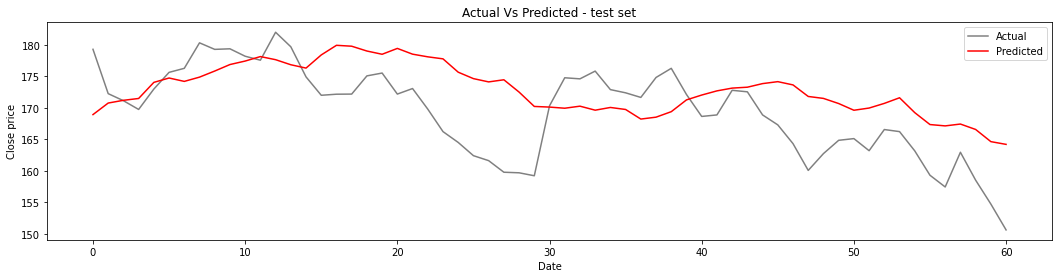

In [ ]:
## make predictions
predictions = model.predict(X_test)
predictions = sc.inverse_transform(predictions)

# Visualising the results
train_size = input[4]
test_size = input[5]

plt.figure(figsize=(18,4))
plt.plot( data['Close'][train_size:train_size+test_size].values, color = 'gray', label = 'Actual')
plt.plot( predictions, color = 'red', label = 'Predicted')
plt.xticks(np.arange(0, test_size, 10))
plt.title('Actual Vs Predicted - test set')
plt.xlabel('Date')
plt.ylabel('Close price')
plt.legend()
plt.show()

# Auto Encoder

The idea behind an **autoencoder** is to train a neural network to **reconstruct its input data** as accurately as possible, by learning to encode the input data into a lower-dimensional representation (the "latent space") and then decoding this representation back into the original input data.

Autoencoders can be used for both regression and classification problems by training them to encode the input data into a lower-dimensional representation that captures the **most important features of the data**, and then using this representation as input to a separate prediction network. The **encoder** part of the autoencoder is used to **extract the features** of the input data, and the **output of the encoder** is fed into a separate network that is trained to predict the class labels of the input data (classification) or to generate the predicted output value (regression).

The advantage of using an autoencoder is that it can learn to extract the most important features of the data in an **unsupervised** manner, without the need for labeled data. This can be particularly useful in cases where labeled data is scarce or expensive to obtain.

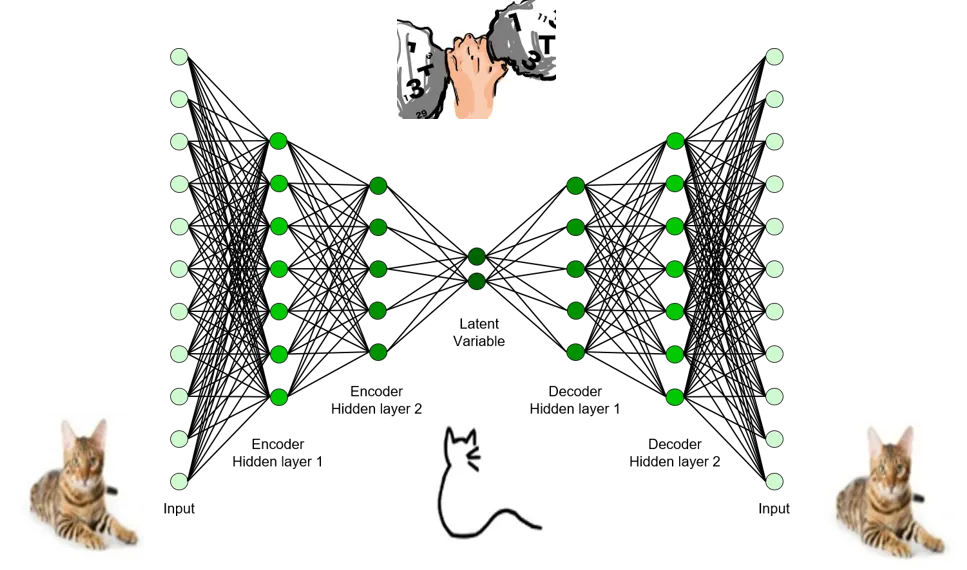
[Source](https://towardsdatascience.com/extreme-rare-event-classification-using-autoencoders-in-keras-a565b386f098)

## AE model for regression

Epoch 1/25
7/7 [==============================] - 1s 29ms/step - loss: 0.1631 - val_loss: 0.5973
Epoch 2/25
7/7 [==============================] - 0s 11ms/step - loss: 0.0920 - val_loss: 0.3220
Epoch 3/25
7/7 [==============================] - 0s 8ms/step - loss: 0.0456 - val_loss: 0.1455
Epoch 4/25
7/7 [==============================] - 0s 7ms/step - loss: 0.0207 - val_loss: 0.0544
Epoch 5/25
7/7 [==============================] - 0s 11ms/step - loss: 0.0107 - val_loss: 0.0223
Epoch 6/25
7/7 [==============================] - 0s 10ms/step - loss: 0.0078 - val_loss: 0.0163
Epoch 7/25
7/7 [==============================] - 0s 11ms/step - loss: 0.0071 - val_loss: 0.0165
Epoch 8/25
7/7 [==============================] - 0s 7ms/step - loss: 0.0063 - val_loss: 0.0170
Epoch 9/25
7/7 [==============================] - 0s 7ms/step - loss: 0.0057 - val_loss: 0.0163
Epoch 10/25
7/7 [==============================] - 0s 10ms/step - loss: 0.0052 - val_loss: 0.0153
Epoch 11/25
7/7 [================

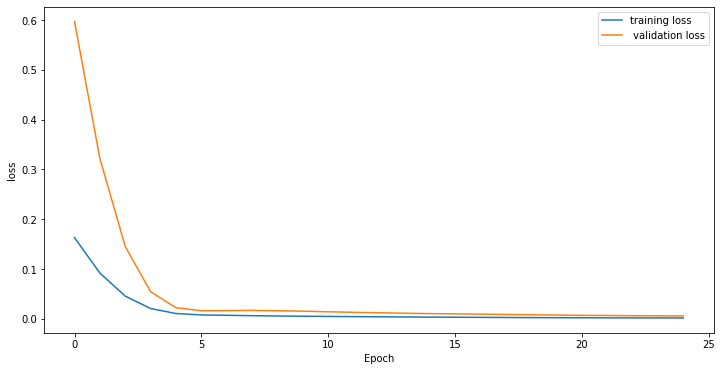

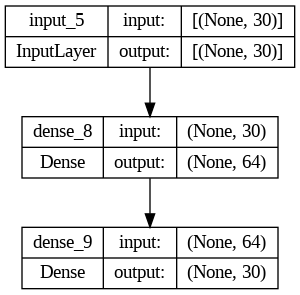

In [ ]:

encoding_dim = 64

# Define autoencoder model
input_layer = Input(shape=(h,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
# encoded = Dense(32, activation='relu')(encoded)
# bottle = Dense(32, activation='relu')(encoded)
# decoded = Dense(16, activation='linear')(encoded)
decoded = Dense(h, activation='linear')(encoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
encoder = Model(inputs=input_layer, outputs=encoded)

autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train autoencoder model
model_fit = autoencoder.fit(X_train, X_train, epochs=25, batch_size=32, validation_data=(X_test, X_test), verbose=1)

# Test autoencoder model
mse = autoencoder.evaluate(X_test, X_test)
print('Test MSE:', round(mse, 4))

## loss plot
plt.figure(figsize=(12,6))
plt.plot(model_fit.history['loss'], label = 'training loss')
plt.plot(model_fit.history['val_loss'], label = ' validation loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.show()

model_plot = plot_model(autoencoder, show_shapes=True)
model_plot



2/2 [==============================] - 0s 7ms/step
Epoch 1/25
7/7 [==============================] - 2s 120ms/step - loss: 0.2287 - val_loss: 0.7268
Epoch 2/25
7/7 [==============================] - 0s 31ms/step - loss: 0.1649 - val_loss: 0.4841
Epoch 3/25
7/7 [==============================] - 0s 28ms/step - loss: 0.1121 - val_loss: 0.3021
Epoch 4/25
7/7 [==============================] - 0s 39ms/step - loss: 0.0726 - val_loss: 0.1738
Epoch 5/25
7/7 [==============================] - 0s 25ms/step - loss: 0.0459 - val_loss: 0.0911
Epoch 6/25
7/7 [==============================] - 0s 25ms/step - loss: 0.0280 - val_loss: 0.0455
Epoch 7/25
7/7 [==============================] - 0s 41ms/step - loss: 0.0181 - val_loss: 0.0236
Epoch 8/25
7/7 [==============================] - 0s 42ms/step - loss: 0.0130 - val_loss: 0.0156
Epoch 9/25
7/7 [==============================] - 0s 14ms/step - loss: 0.0106 - val_loss: 0.0143
Epoch 10/25
7/7 [==============================] - 0s 18ms/step - loss: 0.0

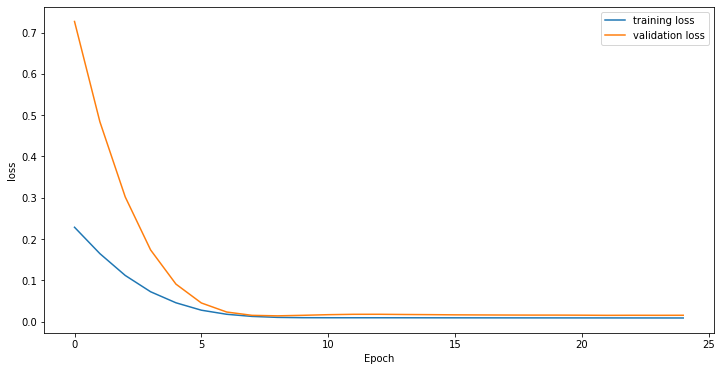

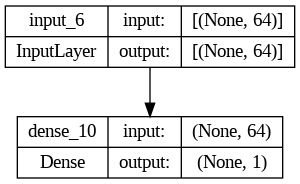

In [ ]:

# Extract encoded features
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

# Define prediction model
input_layer = Input(shape=(encoding_dim,))
output_layer = Dense(1, activation='linear')(input_layer)
prediction_model = Model(inputs=input_layer, outputs=output_layer)
prediction_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')


# Train prediction model
model_fit = prediction_model.fit(X_train_encoded, y_train, epochs=25, batch_size=32, validation_data=(X_test_encoded, y_test), verbose=1)

# Test prediction model
mse = prediction_model.evaluate(X_test_encoded, y_test)
print('Test MSE:', round(mse, 4))


## loss plot
plt.figure(figsize=(12,6))
plt.plot(model_fit.history['loss'], label = 'training loss')
plt.plot(model_fit.history['val_loss'], label = 'validation loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.show()

model_plot = plot_model(prediction_model, show_shapes=True)
model_plot


2/2 [==============================] - 0s 5ms/step


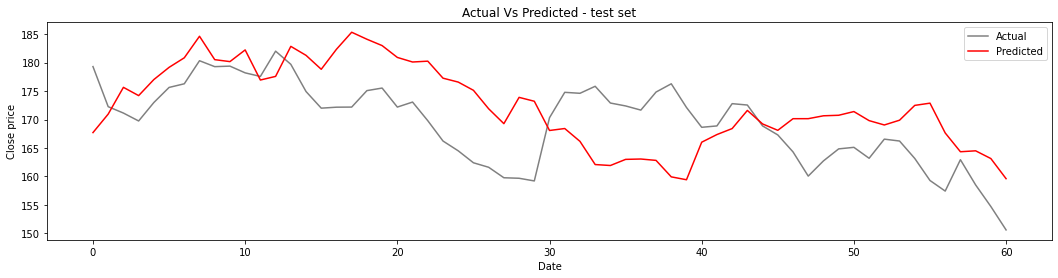

In [ ]:
# Predict on test set
Y_pred = prediction_model.predict(X_test_encoded)
Y_pred = sc.inverse_transform(Y_pred)

# Visualising the results
plt.figure(figsize=(18,4))
plt.plot( data['Close'][train_size:train_size+test_size].values, color = 'gray', label = 'Actual')
plt.plot( Y_pred, color = 'red', label = 'Predicted')
plt.xticks(np.arange(0, test_size, 10))
plt.title('Actual Vs Predicted - test set')
plt.xlabel('Date')
plt.ylabel('Close price')
plt.legend()
plt.show()

## Data for classification

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from google.colab import files

In [ ]:
## Load the dataset and create a dataframe
data_to_load = files.upload()
df = pd.read_csv('diabetes.csv')
df.head(10)


## Replace the zeros with "NaN"
df[["BMI"]]=df[["BMI"]].replace(0,np.NaN)
df[["Insulin"]]=df[["Insulin"]].replace(0,np.NaN)

## Replace the "NaN" values with the mean
df['BMI'].fillna(df['BMI'].mean(), inplace=True)
df['Insulin'].fillna(df['Insulin'].mean(), inplace=True)


## Normalize the numeric features
SC = StandardScaler()
X_to_be_SC = df.drop(['Outcome','Social smoker','Social drinker'], axis=1)
X_CS = SC.fit_transform(X_to_be_SC)
X_CS
X_to_be_SC.columns
X_SC = pd.DataFrame(X_CS, columns=X_to_be_SC.columns)
X_SC.head()


## Specify the feature and target datasets [X and y]
X = pd.concat([X_SC, df[['Social smoker','Social drinker']] ], axis=1 )
y = df[['Outcome']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


Saving diabetes.csv to diabetes.csv


In [ ]:
df

,Pregnancies,Glucose,Pressure,Insulin,BMI,DPF,Age,Social smoker,Social drinker,Outcome
0,0,86,68,155.362007,35.8,0.238,25,1,0,0
1,0,161,50,155.362007,21.9,0.254,65,0,1,0
2,0,121,66,165.000000,34.3,0.203,33,0,0,1
3,0,117,80,53.000000,45.2,0.089,24,1,1,0
4,0,162,76,100.000000,53.2,0.759,25,1,1,1
...,...,...,...,...,...,...,...,...,...,...
495,13,152,90,29.000000,26.8,0.731,43,1,0,1
496,13,104,72,155.362007,31.2,0.465,38,1,0,1
497,14,100,78,184.000000,36.6,0.412,46,0,1,1
498,14,175,62,155.362007,33.6,0.212,38,0,0,1


In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((400, 9), (400, 1), (100, 9), (100, 1))

## AE model for classification

4/4 [==============================] - 0s 3ms/step - loss: 0.4071
Autoencoder Test Loss (MSE): 0.4071


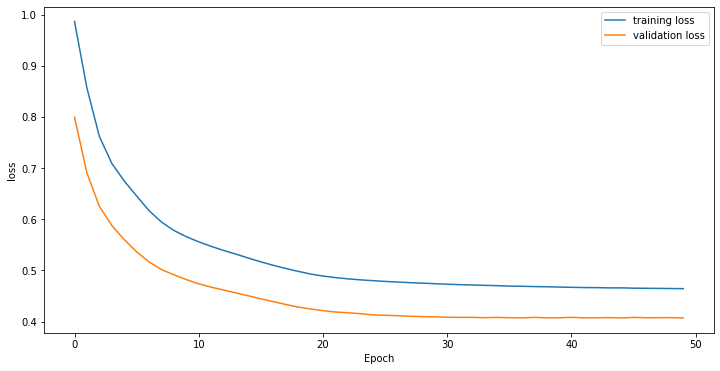

In [ ]:
# Autoencoder model
input_dim = X_train.shape[1]
encoding_dim = 8
input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation='relu')(input_layer)
decoder = Dense(input_dim, activation='sigmoid')(encoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

# Compile the autoencoder model
autoencoder.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

# Train the autoencoder model
model_fit = autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, shuffle=True,
                            validation_data=(X_test, X_test), verbose=0)

# Evaluate the autoencoder model
autoencoder_loss = autoencoder.evaluate(X_test, X_test)
print("Autoencoder Test Loss (MSE):", round(autoencoder_loss,4))


## loss plot
plt.figure(figsize=(12,6))
plt.plot(model_fit.history['loss'], label = 'training loss')
plt.plot(model_fit.history['val_loss'], label = 'validation loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.show()




4/4 [==============================] - 0s 3ms/step


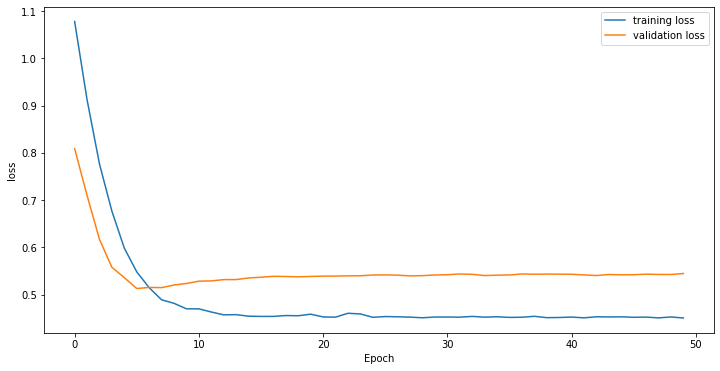

4/4 [==============================] - 0s 6ms/step - loss: 0.5446 - accuracy: 0.7500
Classifier Test Loss: 0.5446
Classifier Test Accuracy: 0.75


In [ ]:
# Extracting the encoder layer
encoder_layer = Model(inputs=input_layer, outputs=encoder)
encoded_X_train = encoder_layer.predict(X_train)
encoded_X_test = encoder_layer.predict(X_test)

# Adding a classifier layer
clf_input_layer = Input(shape=(encoding_dim,))
clf_layer = Dense(1, activation='sigmoid')(clf_input_layer) #This can be any layer such as RNN, CNN, ...
classifier = Model(inputs=clf_input_layer, outputs=clf_layer)

# Compile the classifier
classifier.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

# Train the classifier
model_fit = classifier.fit(encoded_X_train, y_train, epochs=50, batch_size=32, shuffle=True,
               validation_data=(encoded_X_test, y_test), verbose=0)
## loss plot
plt.figure(figsize=(12,6))
plt.plot(model_fit.history['loss'], label = 'training loss')
plt.plot(model_fit.history['val_loss'], label = 'validation loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.show()

# Evaluate the classifier model
classifier_loss, classifier_accuracy = classifier.evaluate(encoded_X_test, y_test)
print("Classifier Test Loss:", round(classifier_loss,4))
print("Classifier Test Accuracy:", round(classifier_accuracy,4))

# Ensemble Deep Learning

https://www.adriangb.com/scikeras/stable/api.html#wrappers

In [ ]:
pip install scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from scikeras.wrappers import KerasClassifier
from sklearn.ensemble import VotingClassifier
from keras.models import Sequential

# define the build_fn function
# def create_model():
#     model = Sequential()
#     model.add(Dense(10, input_dim=9, activation='relu'))
#     model.add(Dense(1, activation='sigmoid'))
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#     return model

# Model 1
model1 = Sequential()
model1.add(Dense(10, input_dim=X_train.shape[1], activation='relu'))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model 2
model2 = Sequential()
model2.add(Dense(12, input_dim=X_train.shape[1], activation='relu'))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model 3
model3 = Sequential()
model3.add(Dense(15, input_dim=X_train.shape[1], activation='relu'))
model3.add(Dense(1, activation='sigmoid'))
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# create the KerasClassifier objects
keras_clf_1 = KerasClassifier(build_fn=model1, epochs=10, batch_size=32, verbose=0)
keras_clf_2 = KerasClassifier(build_fn=model2, epochs=10, batch_size=32, verbose=0)
keras_clf_3 = KerasClassifier(build_fn=model3, epochs=10, batch_size=32, verbose=0)

# create the ensemble model using the VotingClassifier
ensemble_model = VotingClassifier(estimators=[('DNN1', keras_clf_1), ('DNN2', keras_clf_2), ('DANN3', keras_clf_3)])

# train the ensemble model
ensemble_model.fit(X_train, np.ravel(y_train))

# from sklearn.model_selection import StratifiedKFold
# from sklearn.model_selection import cross_val_score
# kfold = StratifiedKFold(n_splits=10, shuffle=True)
# results = cross_val_score(ensemble_model, X, y, cv=kfold)
# print(results.mean())

/usr/local/lib/python3.9/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


VotingClassifier(estimators=[('DNN1',
                              KerasClassifier(batch_size=32, build_fn=<keras.engine.sequential.Sequential object at 0x7f397a08b220>, epochs=10, verbose=0)),
                             ('DNN2',
                              KerasClassifier(batch_size=32, build_fn=<keras.engine.sequential.Sequential object at 0x7f3970364130>, epochs=10, verbose=0)),
                             ('DANN3',
                              KerasClassifier(batch_size=32, build_fn=<keras.engine.sequential.Sequential object at 0x7f3970194dc0>, epochs=10, verbose=0))])

In [ ]:
y_pred = ensemble_model.predict(X_test)
y_pred

array([1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
test_accuracy = ensemble_model.score(X_test, y_test)
print(test_accuracy)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.71
[[57 10]
 [19 14]]
              precision    recall  f1-score   support

           0       0.75      0.85      0.80        67
           1       0.58      0.42      0.49        33

    accuracy                           0.71       100
   macro avg       0.67      0.64      0.64       100
weighted avg       0.69      0.71      0.70       100

